# Notebook for the analysis of XPS data 

Analysis of `dati/Mg_Ag_30V_3p.csv`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from arpes.io import load_data
import xarray as xr


/Users/a129544/anaconda3/envs/XPS/lib/python3.8/site-packages/arpes/config.py:54: UserWarning: Could not find local configuration file. If you don't have one, you can safely ignore this message.
  warnings.warn(msg)


Activating auto-logging. Current session state plus future input saved.
Filename       : logs/unnamed_2023-06-29_15-45-44.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


In [2]:
def load_csv_datatype(path_to_file: str, 
                      n_scans: int= 1,
                      energy_key: str = 'Energy(meas)',
                      dim_name: str = 'eV') -> xr.DataArray:
    """
    This function load a dataset in the csv format using pandas.
    the number of scans need to be manually insered. 
    If multiple scans are present the mean is considered 
    """

    df = pd.read_csv(path_to_file, skiprows=1, sep='\t')

    scan_list = [f'Scan{i}' for i in range(1,n_scans+1)]
    loaded_data = df[scan_list].mean(axis=1).to_numpy()
    
    #loaded_data = [df[key].to_numpy().T for key in scan_list]

    coords = {dim_name : df[energy_key].to_numpy()}

    return xr.DataArray(
        loaded_data,
        coords=coords,
        dims=dim_name,
        # attrs={...} <- attributes here
    )

# Load datas 
In  order to load the datas and to insert them in the `xr.DataArray` object we use a custom function. 
First we analyze the datas importing them with pandas, then we can load them using the function `load_csv_datatype`. This function allow to load datas in the correct format for the successives analysis.

In [3]:
data_path = 'dati/Mg_Ag_30V_3p.csv'

df = pd.read_csv(data_path, skiprows=1, sep='\t')
df

,Energy(calc),Energy(meas),Sum,Scan1,Scan2,Scan3,Scan4,Scan5,Scan6,Scan7
0,710.0,708.02,10019,1354,1471,1502,1486,1371,1437,1398
1,709.7,707.74,9844,1329,1475,1418,1509,1312,1384,1417
2,709.4,707.41,9674,1266,1377,1431,1410,1389,1424,1377
3,709.1,707.11,9761,1262,1391,1467,1474,1412,1384,1371
4,708.8,706.86,9631,1271,1419,1319,1476,1381,1375,1390
...,...,...,...,...,...,...,...,...,...,...
263,631.2,630.43,10505,1512,1522,1598,1552,1421,1409,1491
264,630.9,630.12,10433,1533,1525,1568,1485,1486,1416,1420
265,630.6,629.78,10333,1470,1519,1552,1482,1492,1467,1351
266,630.3,629.48,10443,1447,1530,1608,1498,1520,1446,1394


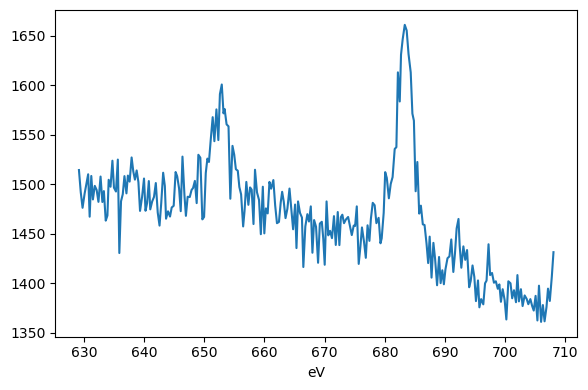

In [4]:
data = load_csv_datatype(path_to_file=data_path, n_scans=7)

# Plot datas
fig, axes = plt.subplots(1, 1, figsize=(6,4))

#data.sum("eV").S.plot(ax=axes)
data.S.plot(ax=axes)

plt.tight_layout()

# Curve fitting 

First let's try just to fit the model without subtract the background 

/var/folders/lg/r7smz1g54tj4bqh1js51y8kc0000gn/T/ipykernel_1663/802313807.py:7: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  selection = df['Energy(meas)'].between(649, 688, inclusive=False).to_numpy()


name,value,min,max,stderr,vary,expr,brute_step
a_amplitude,3607.198,0.000,inf,797.487,True,,
a_center,651.000,651.000,655.000,106.540,True,,
a_fwhm,37.513,-inf,inf,6.805,False,2.3548200*a_sigma,
a_height,90.335,-inf,inf,5.836,False,"0.3989423*a_amplitude/max(1e-15, a_sigma)",
a_sigma,15.930,0.000,inf,2.890,True,,
b_amplitude,937.489,0.000,inf,54.247,True,,
b_center,683.612,680.000,687.000,0.086,True,,
b_fwhm,4.036,-inf,inf,0.230,False,2.3548200*b_sigma,
b_height,218.189,-inf,inf,10.160,False,"0.3989423*b_amplitude/max(1e-15, b_sigma)",
b_sigma,1.714,0.000,inf,0.098,True,,


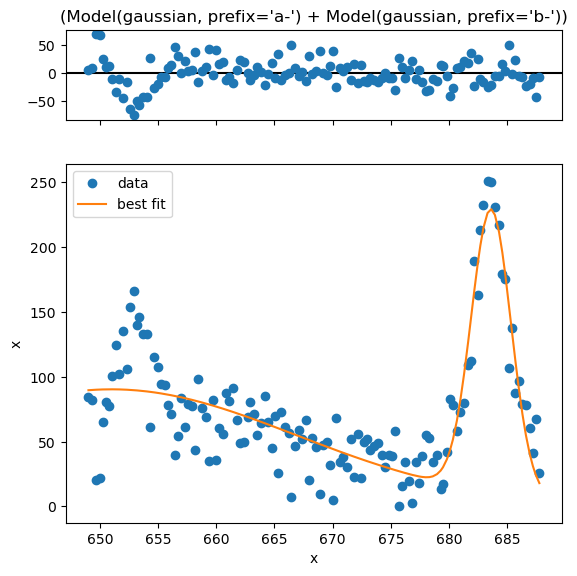

In [5]:
from arpes.fits.fit_models import GaussianModel, AffineBackgroundModel, LorentzianModel, VoigtModel
from arpes.analysis.shirley import remove_shirley_background, calculate_shirley_background_full_range
from arpes.fits.utilities import result_to_hints
#test_curve = data.spectrum.where(ws2_mask & ~wide_peak_mask).mean(["x", "y"]).sel(eV=slice(-36, -31))

# Selection
selection = df['Energy(meas)'].between(649, 688, inclusive=False).to_numpy()

test_curve = data.sel(eV=selection)
test_curve = test_curve - calculate_shirley_background_full_range(test_curve, max_iters=100)

test_model =  GaussianModel(prefix="a_") + GaussianModel(prefix="b_")

result = test_model.guess_fit(
    test_curve - test_curve.min(),
    params={
        "a_center": {"value": 653, "max":655, "min":651 },
        "a_amplitude": {"min": 0},
        "b_center": {"value": 683, "max":687, "min":680},
        "b_amplitude": {"min": 0},
    }
)
result.plot()
result

/var/folders/lg/r7smz1g54tj4bqh1js51y8kc0000gn/T/ipykernel_1663/1831882352.py:5: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  selection = df['Energy(meas)'].between(649, 688, inclusive=False).to_numpy()


name,value,min,max,stderr,vary,expr,brute_step
a_amplitude,333.300,0.000,inf,inf,True,,
a_center,652.937,651.000,655.000,inf,True,,
a_fwhm,3.487,-inf,inf,inf,False,2.3548200*a_sigma,
a_height,89.783,-inf,inf,inf,False,"0.3989423*a_amplitude/max(1e-15, a_sigma)",
a_sigma,1.481,0.000,inf,inf,True,,
b_amplitude,893.755,0.000,inf,inf,True,,
b_center,683.623,680.000,687.000,inf,True,,
b_fwhm,3.887,-inf,inf,inf,False,2.3548200*b_sigma,
b_height,215.997,-inf,inf,inf,False,"0.3989423*b_amplitude/max(1e-15, b_sigma)",
b_sigma,1.651,0.000,inf,inf,True,,


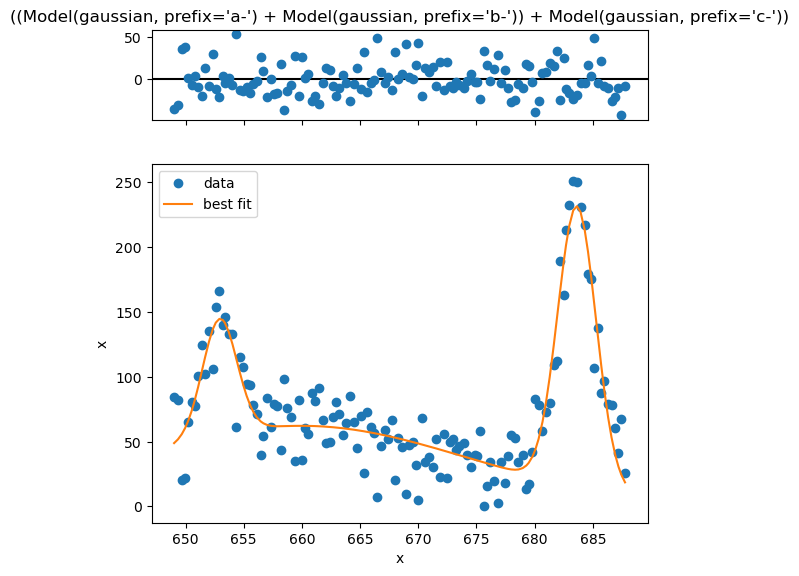

In [6]:
# test_curve = xps.spectrum.where(mask).mean(["x", "y"]).sel(eV=slice(-36, -31))
# test_curve = remove_shirley_background(test_curve)


selection = df['Energy(meas)'].between(649, 688, inclusive=False).to_numpy()
test_curve = data.sel(eV=selection)
#test_curve = remove_shirley_background(test_curve)

test_curve = test_curve - calculate_shirley_background_full_range(test_curve, max_iters=100)

test_model = GaussianModel(prefix="a_") + GaussianModel(prefix="b_") + GaussianModel(prefix="c_") #+ GaussianModel(prefix="d_")

result = test_model.guess_fit(
    test_curve-test_curve.min(),
    params={
       "a_center": {"value": 653, "max":655, "min":651 },
        "a_amplitude": {"min": 0},
        "b_center": {"value": 683, "max":687, "min":680},
        "b_amplitude": {"min": 0},
        "c_center": {"value": 665, "max": 675, "min":660},
        "c_amplitude": {"min": 0.3},
        "c_sigma":{"max": 20, "min": 1},
        "d_center": {"value": 900, "max": 905, "min":895},
        "d_amplitude": {"min": 0},
        "d_sigma":{"max": 10, "min": 1},
    }

)
result.plot()
result

In [7]:
print(result.fit_report())

[[Model]]
    ((Model(gaussian, prefix='a_') + Model(gaussian, prefix='b_')) + Model(gaussian, prefix='c_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 747
    # data points      = 132
    # variables        = 12
    chi-square         = 49912.1146
    reduced chi-square = 415.934288
    Akaike info crit   = 807.448658
    Bayesian info crit = 842.042281
    R-squared          = 0.85662333
##  Warning: uncertainties could not be estimated:
    c_center:     at boundary
    d_center:     at initial value
    d_amplitude:  at boundary
    d_sigma:      at initial value
    d_sigma:      at boundary
[[Variables]]
    a_amplitude:  333.300042 (init = 0)
    a_center:     652.937243 (init = 653)
    a_sigma:      1.48098022 (init = 16.69)
    b_amplitude:  893.754509 (init = 0)
    b_center:     683.623418 (init = 683)
    b_sigma:      1.65074708 (init = 16.69)
    c_amplitude:  2214.38550 (init = 0.3)
    c_center:     660.000000 (init = 665)
    c_sigma:

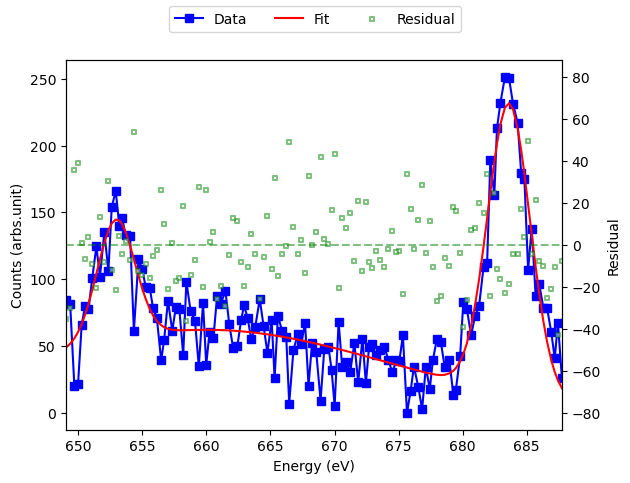

In [8]:
def plot_fit(model_result, ax=None):
    """Performs a straightforward plot of the data, residual, and fit to an axis."""
    if ax is None:
        fig, ax = plt.subplots()

    x = model_result.userkws[model_result.model.independent_vars[0]]
    ax2 = ax.twinx()
    ax2.grid(False)
    ax2.axhline(0, color="green", linestyle="--", alpha=0.5)

    ax.plot(x, model_result.data, color="blue", marker="s", linewidth=1.5, label='Data')
    ax.plot(x, model_result.best_fit, color="red", linewidth=1.5, label='Fit')

    ax2.scatter(
        x,
        model_result.residual,
        edgecolors="green",
        alpha=0.5,
        s=12,
        marker="s",
        c="white",
        linewidth=1.5,
        label='Residual'
    )
    ylim = np.max(np.abs(np.asarray(ax2.get_ylim()))) * 1.5
    ax2.set_ylim([-ylim, ylim])
    ax.set_xlim([np.min(x), np.max(x)])
    ax2.set_ylabel('Residual')
    ax.set_ylabel('Counts (arbs.unit)')
    ax.set_xlabel('Energy (eV)')
    




fig, ax = plt.subplots(1,1)
plot_fit(result, ax=ax)

fig.legend(loc='upper center', ncol=3)